# Titanic - Machine Learning from Disaster
2022-03-22 start  
https://www.kaggle.com/competitions/titanic

In [1]:
import pandas as pd

## Data processing

In [2]:
train = pd.read_csv("datasets/titanic/train.csv")

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


사람 이름과 티켓, Cabin, 승객 ID와 출발지는 결과에 영향을 주지 않는다.  
(티켓과 cabin의 경우 너무 난해해서...)

In [4]:
train = train.drop("Name", axis=1)
train = train.drop("Ticket", axis=1)
train = train.drop("Cabin", axis=1)
train = train.drop("PassengerId", axis=1)
train = train.drop("Embarked", axis=1)

In [5]:
print(train.shape)

(891, 7)


결측값 처리 필요 col : Age

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
dtypes: float64(2), int64(4), object(1)
memory usage: 48.9+ KB


In [7]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


나이의 경우 20대~30대에 몰려있는 경향이 있으므로 평균값으로 대체해주자.

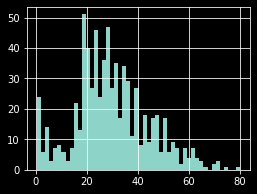

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')
train["Age"].hist(bins=50, figsize=(4, 3))
plt.show()

In [9]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median") # 기본값은 mean 평균값으로 대체한다.

P-class, 성별은 One-hot 인코딩으로 진행해보자.

In [10]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

<AxesSubplot:>

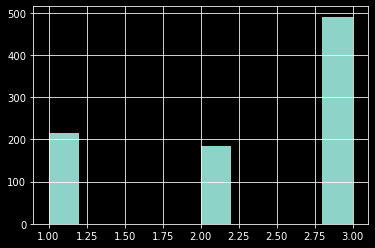

In [11]:
import numpy as np
train["Pclass"].hist()

P-class (좌석 등급)에 따라서 생존 여부가 결정되는 경향을 보인다.  
훈련-테스트 셋을 나눌 때, P-class를 기준으로 동일한 비율을 가지게 나눠준다.  
StratifiedShuffleSplit 이용

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit as SSS

# n_splits는 몇 번 섞을지 결정
# StratifiedShuffleSplit이 알아서 각 계층에서 동일한 비율을 가지고 샘플을 뽑게 해준다.
split = SSS(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(train, train["Pclass"]):
    strat_train_set = train.loc[train_index]
    strat_test_set = train.loc[test_index]

In [13]:
train_X = strat_train_set.drop("Survived", axis=1)
train_y = strat_train_set["Survived"]

In [14]:
test_X = strat_test_set.drop("Survived", axis=1)
test_y = strat_test_set["Survived"]

In [15]:
# 변환 단계가 많기 때문에 연속된 변환을 처리하여 주는 Pipeline 클래스를 이용

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                         ('std_scaler', StandardScaler())])

In [16]:
# ColumnTransformer는 서로다른 col들이 독립적으로 transformer(달라도 됨)을 적용받게 해준다.
# 이후 이들을 합쳐주는 역할을 하는데 만약 희소 행렬과 밀집 행렬이 섞여있으면 밀집 정도에 따라 결정

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

ordi_encoder = OrdinalEncoder()

numeric_val = ["Age", "Fare", "SibSp", "Parch"]
one_hot_val = ["Sex", "Pclass"]
#ordi_val = ["Embarked"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, numeric_val),
    ("one_hot", OneHotEncoder(), one_hot_val),
])

In [17]:
train_prepared = full_pipeline.fit_transform(train_X)

In [18]:
train_y = (train_y == 1)
print(train_y)

820     True
439    False
821     True
403    False
343    False
       ...  
13     False
789    False
51     False
625    False
144    False
Name: Survived, Length: 712, dtype: bool


## model selection

SGDClassifier 와 RandomForestClassifier를 비교해봤는데 후자가 성능이 더 좋게 나온다.  
GridSearchCV로 최적의 파라미터를 찾자

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier()
# dict에 있는 모든 조합들을 시도해보고 최적의 파라미터를 반환하여준다.
param_grid = [{
    "min_samples_leaf": [3],
    "min_samples_split": [5, 6, 7, 8],
    "n_estimators": [45, 46, 47, 48],
    'max_features': [3, 4, 5],
    'max_depth': [7, 8, 9, 10],
}]

grid_search = GridSearchCV(forest_clf,
                           param_grid,
                           cv=10,
                           scoring='accuracy',
                           return_train_score=True)
grid_search.fit(train_prepared, train_y.ravel())
print(grid_search.best_params_)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

{'max_depth': 9, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 46}
RandomForestClassifier(max_depth=9, max_features=4, min_samples_leaf=3,
                       min_samples_split=5, n_estimators=46)
0.8384976525821596


In [20]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
import warnings

warnings.filterwarnings('ignore')

SGD_clf = SGDClassifier()
param_grid2 = [{
    'max_iter': [2000, 2500, 3000, 3500],
    'tol': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
    'eta0': [0.1, 0.01, 0.001, 0.0001],
    'penalty': ['l1', 'elasticnet'],
    'l1_ratio': [0.15, 0.3, 0.45, 0.6],
    'learning_rate': ['constant', 'optimal'],
}]

#grid_search2 = GridSearchCV(SGD_clf,param_grid2,cv=10,
#                          scoring='accuracy',
#                          return_train_score=True)
#grid_search2.fit(train_prepared,train_y.ravel())
#print(grid_search2.best_params_)
#print(grid_search2.best_estimator_)
#print(grid_search2.best_score_)

In [21]:
best_clf = grid_search.best_estimator_
print(test_y.shape)
print(test_X.shape)
test_prepared = full_pipeline.fit_transform(test_X)
print(train_prepared.shape)
print(test_prepared.shape)

(179,)
(179, 6)
(712, 9)
(179, 9)


In [22]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label="정밀도")
    plt.plot(thresholds,recalls[:-1],"g-",label="재현율")
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)

In [23]:
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict

y_scores = cross_val_predict(best_clf,
                             train_prepared,
                             train_y.ravel(),
                             cv=3,
                             method="predict_proba")
#randomforest는 decision_function대신 predict_proba 이용

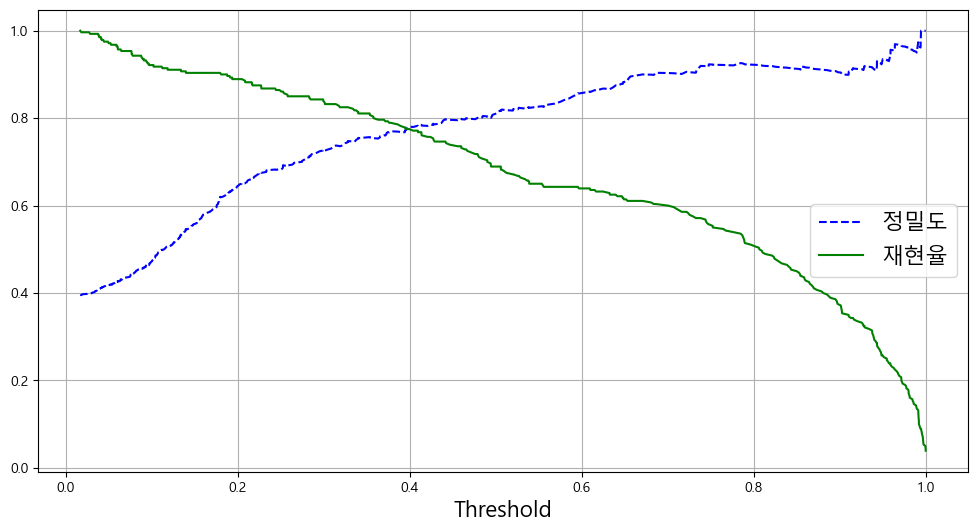

In [24]:
from matplotlib import rc

plt.style.use('default')
plt.figure(figsize=(12,6))
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

precisions, recalls, thresholds = precision_recall_curve(
    train_y.ravel(), y_scores[:,1])

plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

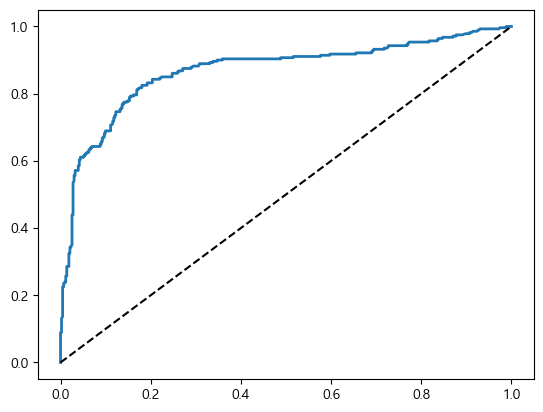

In [25]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(train_y.ravel(),y_scores[:,1])

plt.plot(fpr,tpr,linewidth=2,label=None)
plt.plot([0,1],[0,1],'k--')

plt.show()

In [26]:
from sklearn.metrics import roc_auc_score

roc_auc_score(train_y.ravel(),y_scores[:,1])

0.8689360119047619

## 결과 검증 및 제출

In [27]:
from sklearn.model_selection import cross_val_score

final_scores = cross_val_score(best_clf,
                               test_prepared,
                               test_y.ravel(),
                               scoring="accuracy",
                               cv=10)
print(final_scores.mean())

0.7705882352941176


In [28]:
final = pd.read_csv("datasets/titanic/test.csv")
result = final

In [29]:
final

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [30]:
final = final.drop("Name", axis=1)
final = final.drop("Ticket", axis=1)
final = final.drop("Cabin", axis=1)
final = final.drop("PassengerId", axis=1)
final_prepared = full_pipeline.fit_transform(final)
result["Survived"] = best_clf.predict(final_prepared)
result

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,False
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,True
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,False
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,False
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,False
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,False
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,True
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,False
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,False


In [31]:
submission = result[['PassengerId', 'Survived']].copy()
submission["Survived"] = submission["Survived"].astype(int)

In [32]:
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [33]:
submission.to_csv('submission.csv', index=False)